In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import numpy as np
from collections import Counter
import random

In [ ]:
!pip install torchinfo

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=60).to(device)

# 5. Unfreeze the last two transformer encoder blocks
# torchvision ViT has an attribute `encoder.layers` containing all transformer blocks
num_blocks = len(pretrained_vit.encoder.layers)

# Unfreeze the last one block
for block in pretrained_vit.encoder.layers[-12:]:
    for parameter in block.parameters():
        parameter.requires_grad = True

# Access the LayerNorm layer
layernorm = pretrained_vit.encoder.ln

# Unfreeze its parameters
for parameter in layernorm.parameters():
    parameter.requires_grad = True

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 172MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 60]                  768                       Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   Partial
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        True
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            7,087,872                 True
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768] 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
Train_dataset_path = '/content/drive/MyDrive/Reverse/Train'
Validation_dataset_path = '/content/drive/MyDrive/Reverse/Validation'
Test_dataset_path = '/content/drive/MyDrive/Reverse/Test'

models_path='/content/drive/My Drive/Thesis_ViT_Models/UnfrozenViT80percent.pth'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Create datasets for each directory
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained = create_dataloaders(
    train_dir=Train_dataset_path,
    val_dir=Validation_dataset_path,
    test_dir=Test_dataset_path,
    transform=pretrained_vit_transforms,
    batch_size=32
)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
                              train_dataloader: torch.utils.data.DataLoader,
                              test_dataloader: torch.utils.data.DataLoader,
                              optimizer: torch.optim.Optimizer,
                              loss_fn: torch.nn.Module,
                              epochs: int,
                              device: torch.device,
                              patience: int) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model with early stopping.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    patience: An integer indicating how many epochs to wait for improvement
              in validation loss before stopping early.

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics.
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model is on target device
    model.to(device)

    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Check for improvement
        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0  # Reset counter if improvement is found
        else:
            patience_counter += 1

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    # Return the filled results at the end of the epochs
    return results

In [ ]:
#Loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.AdamW(params=pretrained_vit.parameters(),
                             lr=1e-4)

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device,
                                      patience=3)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0253 | train_acc: 0.8071 | test_loss: 0.1134 | test_acc: 0.9844
Epoch: 2 | train_loss: 0.0389 | train_acc: 0.9946 | test_loss: 0.0740 | test_acc: 0.9918
Epoch: 3 | train_loss: 0.0114 | train_acc: 0.9994 | test_loss: 0.0537 | test_acc: 0.9918
Epoch: 4 | train_loss: 0.0060 | train_acc: 0.9996 | test_loss: 0.0569 | test_acc: 0.9918
Epoch: 5 | train_loss: 0.0059 | train_acc: 0.9994 | test_loss: 0.0497 | test_acc: 0.9918
Epoch: 6 | train_loss: 0.0040 | train_acc: 0.9994 | test_loss: 0.0512 | test_acc: 0.9926
Epoch: 7 | train_loss: 0.0042 | train_acc: 0.9994 | test_loss: 0.0531 | test_acc: 0.9918
Epoch: 8 | train_loss: 0.0036 | train_acc: 0.9994 | test_loss: 0.0491 | test_acc: 0.9918
Epoch: 9 | train_loss: 0.0029 | train_acc: 0.9994 | test_loss: 0.0523 | test_acc: 0.9918
Epoch: 10 | train_loss: 0.0029 | train_acc: 0.9994 | test_loss: 0.0486 | test_acc: 0.9918
Epoch: 11 | train_loss: 0.0023 | train_acc: 0.9992 | test_loss: 0.0507 | test_acc: 0.9918
Epoch: 12 | train_l

In [ ]:
#Save the model
torch.save(obj=pretrained_vit.state_dict(), f=models_path)

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

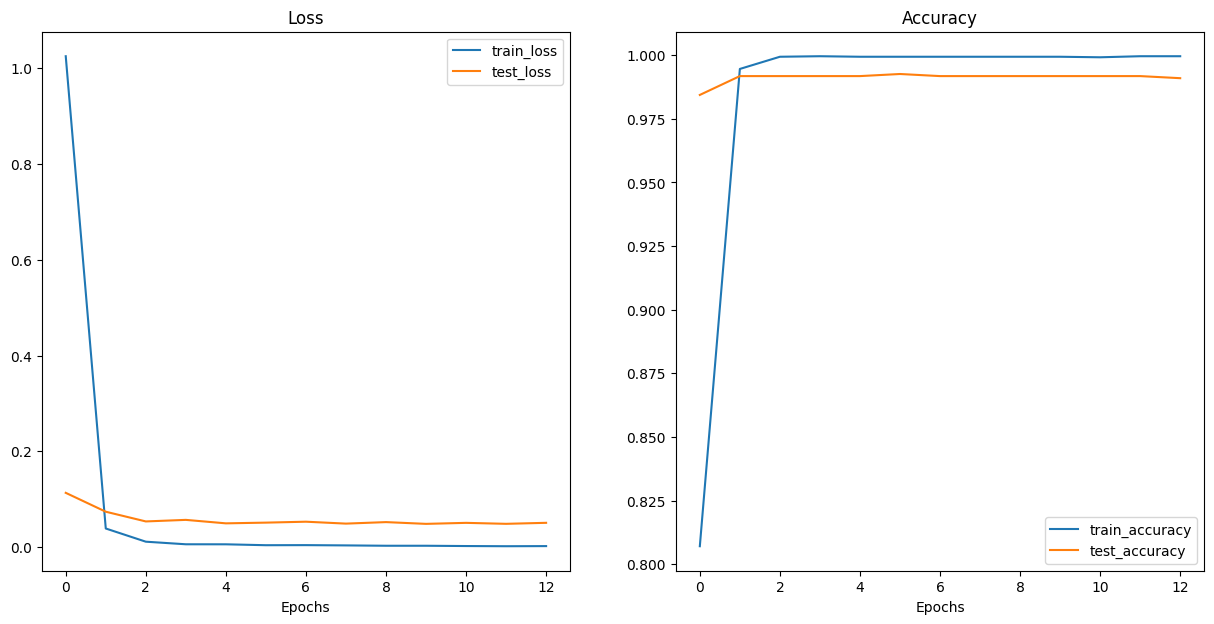

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Load the model
pretrained_vit.load_state_dict(torch.load(models_path))

# Perform evaluation on the test set
final_test_loss, final_test_acc = test_step(
    model=pretrained_vit,
    dataloader=test_dataloader_pretrained,
    loss_fn=loss_fn,
    device=device
)

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")

<ipython-input-17-d716ec1e9f9e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_vit.load_state_dict(torch.load(models_path))


Final Test Loss: 0.0508
Final Test Accuracy: 0.9910


In [ ]:
#Measure inference time on L4 GPU
import time

# Load the trained model
pretrained_vit.load_state_dict(torch.load(models_path))
pretrained_vit.eval().to(device)

# Measure inference time
total_time = 0
num_samples = 0

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader_pretrained):
        X = X.to(device)
        num_samples += X.shape[0]

        start_time = time.time()  # Start timing
        _ = pretrained_vit(X)  # Forward pass
        end_time = time.time()  # End timing

        total_time += (end_time - start_time)

# Compute average inference time per image
avg_inference_time = total_time / num_samples

print(f"Average Inference Time per Image: {avg_inference_time:.6f} seconds")

<ipython-input-15-e56ef4aab2e4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_vit.load_state_dict(torch.load(models_path))


Average Inference Time per Image: 0.000208 seconds
